<a href="https://colab.research.google.com/github/ptx-pluto/colab-notebooks/blob/master/drake_2d_cable_swing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import importlib
import os, sys
from urllib.request import urlretrieve

if 'google.colab' in sys.modules and importlib.util.find_spec('manipulation') is None:
    urlretrieve(f"http://manipulation.csail.mit.edu/scripts/setup/setup_manipulation_colab.py",
                "setup_manipulation_colab.py")
    from setup_manipulation_colab import setup_manipulation
    setup_manipulation(manipulation_sha='47a354700b3bc48861400bbe4eb16ad54cf08c05', drake_version='0.25.0', drake_build='releases')

from IPython import get_ipython
running_as_notebook = get_ipython() and hasattr(get_ipython(), 'kernel')

# setup ngrok server
server_args = []
if 'google.colab' in sys.modules:
  server_args = ['--ngrok_http_tunnel']

import numpy as np
from IPython.display import display, HTML
from pydrake.examples.manipulation_station import ManipulationStation

import matplotlib.pyplot as plt, mpld3
if running_as_notebook:
  mpld3.enable_notebook()

import pydrake
from pydrake.all import (
    DiagramBuilder, ConnectMeshcatVisualizer, Simulator, FindResourceOrThrow,
    Parser, MultibodyPlant, RigidTransform, LeafSystem, BasicVector,
    JacobianWrtVariable, RollPitchYaw, SignalLogger, AddTriad,
    PiecewisePolynomial, PiecewiseQuaternionSlerp, RotationMatrix, Solve,
    TrajectorySource, ConstantVectorSource
)
from pydrake.multibody import inverse_kinematics
from pydrake.all import SnoptSolver, IpoptSolver
from pydrake.trajectories import PiecewisePolynomial

from pydrake.symbolic import Variable
from pydrake.systems.primitives import SymbolicVectorSystem

import math
from pydrake.math import *

In [ ]:
from pydrake.systems.primitives import LogOutput
# drake
from pydrake.all import (MultibodyPlant, Parser, DiagramBuilder, Simulator,
                         PlanarSceneGraphVisualizer, SceneGraph, TrajectorySource,
                         SnoptSolver, MultibodyPositionToGeometryPose, PiecewisePolynomial,
                         MathematicalProgram, JacobianWrtVariable, eq)

In [ ]:
T = 50
mass = 1
cable_length = 1
dt = 0.02
g = 9.8


prog = MathematicalProgram()
# state vector (x, y, theta, l, T)
q = prog.NewContinuousVariables(rows=T+1, cols=5, name='q')
qd = prog.NewContinuousVariables(rows=T+1, cols=5, name='qd')
qdd = prog.NewContinuousVariables(rows=T, cols=5, name='qdd')

# initial configuration
# load at origin, stationary
prog.AddLinearConstraint( q[0,0] == 0 )
prog.AddLinearConstraint( q[0,1] == 0 )
prog.AddLinearConstraint( q[0,2] == math.pi/2 )
prog.AddLinearConstraint( q[0,3] == cable_length )
prog.AddLinearConstraint( qd[0,0] == 0 )
prog.AddLinearConstraint( qd[0,1] == 0 )
prog.AddLinearConstraint( qd[0,2] == 0 )
prog.AddLinearConstraint( qd[0,3] == 0 )

# goal state
# move to (2,0), stationary
prog.AddLinearConstraint( q[T,0] == 2 )
prog.AddLinearConstraint( q[T,1] == -1 )
prog.AddLinearConstraint( q[T,2] == math.pi/2 )
prog.AddLinearConstraint( q[T,3] == cable_length )
prog.AddLinearConstraint( qd[T,0] == 0 )
prog.AddLinearConstraint( qd[T,1] == 0 )
prog.AddLinearConstraint( qd[T,2] == 0 )
prog.AddLinearConstraint( qd[T,3] == 0 )

# collocation constrains
for t in range(T):
    prog.AddConstraint(eq(q[t+1],q[t] + dt * qd[t+1]))
    prog.AddConstraint(eq(qd[t+1],qd[t] + dt * qdd[t]))

# load dynamics
for t in range(T):
    prog.AddConstraint(mass * qdd[t,0] == cos(q[t,2]) * q[t,4])
    prog.AddConstraint(mass * qdd[t,1] == sin(q[t,2]) * q[t,4] - mass * g)

# cable can only pull
for t in range(T):
  prog.AddLinearConstraint(q[t,4] >= 0)

# complimentarity constrain
for t in range(T):
    prog.AddConstraint(q[t,4] * (cable_length-q[t,3]) == 0)

# prefer alway taut
for t in range(T):
    prog.AddCost((cable_length-q[t,3])**2) 
    
# small change in length
for t in range(T):
    prog.AddCost((q[t,3]-q[t+1,3])**2)

# min qdd
for t in range(T):
    prog.AddCost(qdd[t,:].dot(qdd[t,:]))

# cable length constrain
for t in range(T):
    prog.AddBoundingBoxConstraint(0, cable_length, q[t,3])

# atti angle constrain
for t in range(T):
    prog.AddBoundingBoxConstraint(0, np.pi, q[t,2])

In [ ]:
initial_guess = np.empty(prog.num_vars())

prog.SetDecisionVariableValueInVector(q[:,0], [0] * (T+1), initial_guess)
prog.SetDecisionVariableValueInVector(q[:,1], [0] * (T+1), initial_guess)
prog.SetDecisionVariableValueInVector(q[:,3], [np.pi/2] * (T+1), initial_guess)
prog.SetDecisionVariableValueInVector(q[:,3], [cable_length] * (T+1), initial_guess)
prog.SetDecisionVariableValueInVector(q[:,4], [mass*g] * (T+1), initial_guess)
prog.SetDecisionVariableValueInVector(qd, np.zeros((T+1,5)), initial_guess)
prog.SetDecisionVariableValueInVector(qdd, np.zeros((T,5)), initial_guess)


# solve mathematical program with initial guess
solver = SnoptSolver()
result = solver.Solve(prog, initial_guess)

# ensure solution is found
print(f'Solution found? {result.is_success()}.')

Solution found? True.


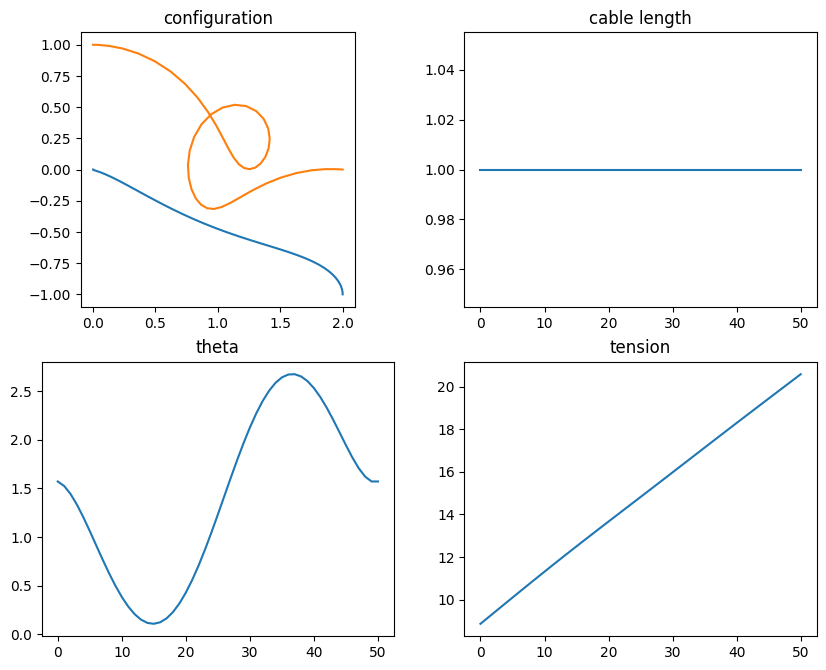

In [ ]:
rst_q = result.GetSolution(q)

traj = np.zeros((T,2))
for t in range(T):
  xl_x = rst_q[t,0]
  xl_y = rst_q[t,1]
  cable = rst_q[t,3]
  atti = rst_q[t,2]
  traj[t,0] = xl_x + cable*np.cos(atti)
  traj[t,1] = xl_y + cable*np.sin(atti)

plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

fig, axs = plt.subplots(2, 2)
axs[0,0].set_aspect('equal')
axs[0,0].set_title("configuration")
axs[0,0].plot(rst_q[:,0],rst_q[:,1])
axs[0,0].plot(traj[:,0],traj[:,1])

axs[0,1].set_title("cable length")
axs[0,1].plot(rst_q[:,3])
axs[1,0].set_title("theta")
axs[1,0].plot(rst_q[:,2])
axs[1,1].set_title("tension")
axs[1,1].plot(rst_q[:,4])

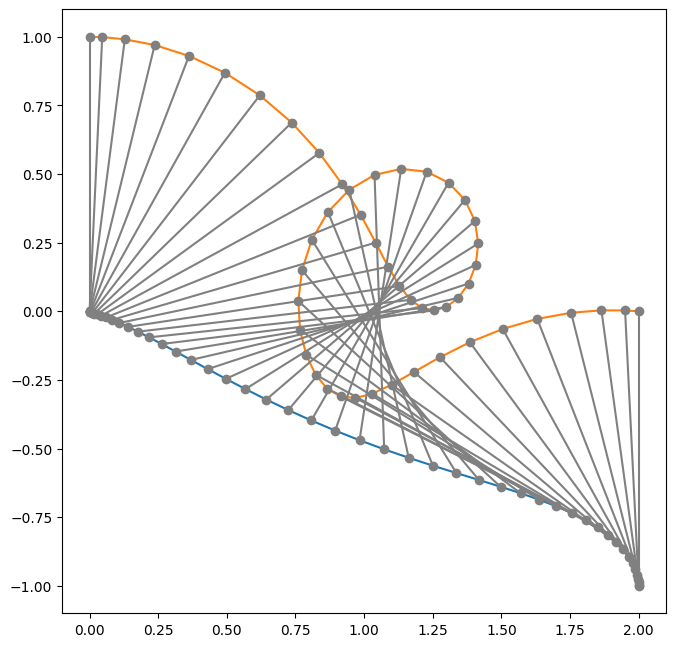

In [ ]:
plt.gca().set_aspect('equal', adjustable='box')

plt.plot(rst_q[:,0],rst_q[:,1])
plt.plot(traj[:,0],traj[:,1])
for i in range(0,T,1):
  plt.plot([traj[i,0],rst_q[i,0]],[traj[i,1],rst_q[i,1]],marker="o",color="gray")


In [ ]:
%matplotlib inline

from matplotlib import animation, rc
from IPython.display import HTML

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

axs[0,0].set_aspect('equal')
ax.set_xlim(( -0.1, 2.1))
ax.set_ylim((-1.1, 1.1))

line, = ax.plot([], [], lw=1, marker="o")

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i):
    line.set_data([traj[i,0],rst_q[i,0]], [traj[i,1],rst_q[i,1]])
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=T, interval=100, blit=True)
plt.close()

HTML(anim.to_jshtml())